In [0]:
import pickle
import pandas as pd
import re
import string
import nltk
from nltk.corpus import stopwords
import sklearn
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
import sklearn.svm as svm
import sklearn.metrics as metrics
import numpy as np

In [0]:
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
depressed_pickle = open("/content/drive/My Drive/Colab Notebooks/dep_data/depressed.pickle","rb")
depressed_dict = pickle.load(depressed_pickle)
depressed_df = pd.DataFrame(depressed_dict)
depressed_df.drop_duplicates(subset=['id'], inplace=True)
print("test Total number of comments: ", sum(depressed_df['num_comments']))

test Total number of comments:  121355


In [0]:
non_depressed_pickle = open("/content/drive/My Drive/Colab Notebooks/dep_data/non_depressed.pickle","rb")
non_depressed_dict = pickle.load(non_depressed_pickle)
non_depressed_df = pd.DataFrame(non_depressed_dict)
non_depressed_df.drop_duplicates(subset=['id'], inplace=True)
print("test Total number of comments: ", sum(non_depressed_df['num_comments']))

test Total number of comments:  178277


In [0]:
depressed_comments_arr = depressed_df['comments'].tolist()
non_depressed_comments_arr = non_depressed_df['comments'].tolist()

In [0]:
depressed_comments = [comment for post in depressed_df['comments'] for comment in post]
non_depressed_comments = [comment for post in non_depressed_df['comments'] for comment in post]

In [0]:
print("depressed length ", len(depressed_comments))
print("non depressed length ", len(non_depressed_comments))

depressed length  116900
non depressed length  127911


In [0]:
def clean_one_comment(comment):
    comment = comment.lower()
    # remove /r/, /u/, numbers
    comment = re.sub(r"(\/r\/)|(\/u\/)|(\d+)","",comment)
    # remove punctuation
    comment = comment.translate(str.maketrans('','', string.punctuation))
    # replacing ' 
    comment = comment.replace('’','')
    comment = comment.replace('\n'," ")
    # remove trailing whitespace
    comment = comment.strip()
    return comment


In [0]:
def clean_comments(comments):
    removed_comments = ['[deleted]', '[removed]']
    filtered_comments = [comment for comment in comments if comment not in removed_comments]
    comments_clean = list()
    for comment in filtered_comments:
        comment_new = clean_one_comment(comment)
        comments_clean.append(comment_new)
    return comments_clean

In [0]:
print('orig length: ', len(depressed_comments))
print(depressed_comments[:10])
depressed_comments_cleaned = clean_comments(depressed_comments)
print('cleaned length: ', len(depressed_comments_cleaned))

orig length:  116900
["Sorry if I'm stupid, but what's activism? I don't want to accidentally break the rules", 'Ah thank you, usually I just see it as a load of horsecrap of people wanting to feel good by repeating lines of comfort words to a person and thinking they did some good not knowing that they made a depressed person lose eveb more hope and reason to live with their plastic character. Some genuinely care but not all.', 'Lol somebody in my town thought that day was a good day for suicide good job. Small town of like 14k citizens 5 suicides under 18 in 1 year. Thinking about joining the club as well.', 'I really appreciate this post. The "activism" and "awareness" days are honestly so triggering for me that I\'d like to pretend they don\'t exist.', 'donate to my mom lol\n\n&#x200B;', '[removed]', '[deleted]', '[deleted]', '[deleted]', "Basically anything that's aimed at raising awreness (or money) among the general public.  Totally out of place in a support community.  Our prob

In [0]:
non_depressed_comments_cleaned = clean_comments(non_depressed_comments)
print('cleaned length: ', len(non_depressed_comments_cleaned))

cleaned length:  127559


In [0]:
depressed_df = pd.DataFrame(depressed_comments_cleaned)
depressed_df.columns = ['text']
depressed_df['label'] = 1 # note 1 = depressed, 0 = not depressed
depressed_df

,text,label
0,sorry if im stupid but whats activism i dont w...,1
1,ah thank you usually i just see it as a load o...,1
2,lol somebody in my town thought that day was a...,1
3,i really appreciate this post the activism and...,1
4,donate to my mom lol xb,1
...,...,...
111957,amazon barnes and noble wherever its meant for...,1
111958,bad timing dumb bot,1
111959,i hear i do hear ya see if you have any resour...,1
111960,thx kind internet person its been a while,1


In [0]:
non_depressed_df = pd.DataFrame(non_depressed_comments_cleaned)
non_depressed_df.columns = ['text']
non_depressed_df['label'] = 0
non_depressed_df

,text,label
0,his dad developed huntingtons and his mom left...,0
1,got back together with him after years apart ...,0
2,she met someone like a decade ago and theyve b...,0
3,she is a therapist and happily married,0
4,she was an exchange student who i was absolute...,0
...,...,...
127554,from a buick is hands down my favorite king n...,0
127555,yes the illustrations were so creepy,0
127556,hell no but i will end up watching it regardless,0
127557,i think its super underrated many king fans ha...,0


In [0]:
df = pd.concat([depressed_df, non_depressed_df]).reset_index(drop=True)
df

,text,label
0,sorry if im stupid but whats activism i dont w...,1
1,ah thank you usually i just see it as a load o...,1
2,lol somebody in my town thought that day was a...,1
3,i really appreciate this post the activism and...,1
4,donate to my mom lol xb,1
...,...,...
239516,from a buick is hands down my favorite king n...,0
239517,yes the illustrations were so creepy,0
239518,hell no but i will end up watching it regardless,0
239519,i think its super underrated many king fans ha...,0


In [0]:
df = shuffle(df).reset_index(drop=True)
df

,text,label
0,died by suicide im happily married but i think...,0
1,tied between arcanine and ninetails maybe im a...,0
2,has anyone broken this cycle i hate this feeli...,1
3,this has upvotes and votes atm and not a sin...,1
4,multiple times a day i want to talk to people ...,1
...,...,...
239516,enjoying the companionship of an animal to hav...,0
239517,wow totally understand stuck,1
239518,hold up,0
239519,i used to listen to my headphones really loudl...,0


In [0]:
vectorizer = TfidfVectorizer(min_df=2,norm='l2')

In [0]:
xy, test = train_test_split(df, test_size=0.2)
train, dev = train_test_split(xy, test_size=0.25)

In [0]:
print(len(train))
print(len(dev))
print(len(test))

143712
47904
47905


In [0]:
train

,text,label
145622,even if it has to believe at times mankind is ...,0
226313,okay that was kinda creepy because all three a...,1
86695,nothing i wish i were in the next life,0
194454,diamond rio,0
147259,youre taking a fair bit of issue with a simple...,0
...,...,...
88351,nobodys said it yet so happy birthday,1
744,having money,0
68453,female similar re finances,1
37109,converting motorcycles,0


In [0]:
test

,text,label
141896,death by a thousand cuts is a oriental one the...,0
88064,im constantly going through my social media pa...,0
232276,i didnt say that i knew i would be ok im just ...,0
110734,this you httpswwwredditcomtifucommentsaqcztifu...,0
117344,same here,1
...,...,...
109560,haha i have not just googld it and sure will w...,0
131911,exact same situation here dropped out and chan...,1
147345,o o f,0
16631,i forgot about it i was yrs old my bother set...,1


In [0]:
X_train = train['text']
y_train = train['label']
X_dev = dev['text']
y_dev = dev['label']
X_test = test['text']
y_test = test['label']

In [0]:
Xv_train = vectorizer.fit_transform(X_train)
Xv_dev = vectorizer.transform(X_dev)
Xv_test = vectorizer.transform(X_test)
from sklearn.metrics import confusion_matrix

In [0]:
C_param = [0.1,0.25,0.3,0.4,0.5,1,10,100]
for c in C_param:
    print("=============================================")
    print("C: ", c)
    lr = LogisticRegression(C=c)
    lr.fit(Xv_train, y_train)
    preds = lr.predict(Xv_dev)
    print("Accuracy ", metrics.accuracy_score(y_dev, preds))
    print("Precision ", metrics.precision_score(y_dev, preds))
    print("Recall ", metrics.recall_score(y_dev, preds))
    print("F1 score ", metrics.f1_score(y_dev, preds))
    print(metrics.classification_report(y_dev, preds))
    print(confusion_matrix(y_dev, preds))


C:  0.1
Accuracy  0.8288034402137608
Precision  0.850167191188041
Recall  0.7703515572784387
F1 score  0.8082937890086258
              precision    recall  f1-score   support

           0       0.81      0.88      0.85     25461
           1       0.85      0.77      0.81     22443

    accuracy                           0.83     47904
   macro avg       0.83      0.83      0.83     47904
weighted avg       0.83      0.83      0.83     47904

[[22414  3047]
 [ 5154 17289]]
C:  0.25
Accuracy  0.8381346025384101
Precision  0.8540029883838627
Recall  0.7894666488437375
F1 score  0.8204677008566799
              precision    recall  f1-score   support

           0       0.83      0.88      0.85     25461
           1       0.85      0.79      0.82     22443

    accuracy                           0.84     47904
   macro avg       0.84      0.84      0.84     47904
weighted avg       0.84      0.84      0.84     47904

[[22432  3029]
 [ 4725 17718]]
C:  0.3
Accuracy  0.8398254843019372
P

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Accuracy  0.8473405143620575
Precision  0.8556987022757194
Recall  0.81089872120483
F1 score  0.832696575232779
              precision    recall  f1-score   support

           0       0.84      0.88      0.86     25461
           1       0.86      0.81      0.83     22443

    accuracy                           0.85     47904
   macro avg       0.85      0.85      0.85     47904
weighted avg       0.85      0.85      0.85     47904

[[22392  3069]
 [ 4244 18199]]
C:  10


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Accuracy  0.8481128924515698
Precision  0.8452538128841338
Recall  0.8272512587443747
F1 score  0.8361556476310574
              precision    recall  f1-score   support

           0       0.85      0.87      0.86     25461
           1       0.85      0.83      0.84     22443

    accuracy                           0.85     47904
   macro avg       0.85      0.85      0.85     47904
weighted avg       0.85      0.85      0.85     47904

[[22062  3399]
 [ 3877 18566]]
C:  100


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Accuracy  0.8380511022044088
Precision  0.8298665708252841
Recall  0.8230628703827474
F1 score  0.8264507180886761
              precision    recall  f1-score   support

           0       0.85      0.85      0.85     25461
           1       0.83      0.82      0.83     22443

    accuracy                           0.84     47904
   macro avg       0.84      0.84      0.84     47904
weighted avg       0.84      0.84      0.84     47904

[[21674  3787]
 [ 3971 18472]]


In [0]:

C_param = [0.1,0.25,0.3,0.4,0.5,1,10,100]
for c in C_param:
    print("=======================================================")
    print("C: ", c)
    model = svm.LinearSVC(C=c)
    model.fit(Xv_train, y_train)
    preds = model.predict(Xv_dev)
    print("Acc ", metrics.accuracy_score(y_dev, preds))
    print("Precision ", metrics.precision_score(y_dev, preds))
    print("Recall ", metrics.recall_score(y_dev, preds))
    print("F1 score ", metrics.f1_score(y_dev, preds))
    print(metrics.classification_report(y_dev, preds))
    print(confusion_matrix(y_dev, preds))

C:  0.1
Acc  0.8472152638610554
Precision  0.8572710951526032
Recall  0.8084926257630441
F1 score  0.8321676718108648
              precision    recall  f1-score   support

           0       0.84      0.88      0.86     25461
           1       0.86      0.81      0.83     22443

    accuracy                           0.85     47904
   macro avg       0.85      0.84      0.85     47904
weighted avg       0.85      0.85      0.85     47904

[[22440  3021]
 [ 4298 18145]]
C:  0.25
Acc  0.8496576486305946
Precision  0.8536687241843413
Recall  0.8195873991890568
F1 score  0.8362809729483974
              precision    recall  f1-score   support

           0       0.85      0.88      0.86     25461
           1       0.85      0.82      0.84     22443

    accuracy                           0.85     47904
   macro avg       0.85      0.85      0.85     47904
weighted avg       0.85      0.85      0.85     47904

[[22308  3153]
 [ 4049 18394]]
C:  0.3
Acc  0.8492818971275885
Precision  0.85

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Acc  0.8157565130260521
Precision  0.7891942403262117
Recall  0.8278750612663192
F1 score  0.8080720219197148
              precision    recall  f1-score   support

           0       0.84      0.81      0.82     25461
           1       0.79      0.83      0.81     22443

    accuracy                           0.82     47904
   macro avg       0.82      0.82      0.82     47904
weighted avg       0.82      0.82      0.82     47904

[[20498  4963]
 [ 3863 18580]]


In [0]:
lr = LogisticRegression(C=1)
lr.fit(Xv_train, y_train)
preds = lr.predict(Xv_test)
print("Acc ", metrics.accuracy_score(y_test, preds))
print("Precision ", metrics.precision_score(y_test, preds))
print("Recall ", metrics.recall_score(y_test, preds))
print("F1 score ", metrics.f1_score(y_test, preds))
print(metrics.classification_report(y_test, preds))
print(confusion_matrix(y_test, preds))


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Acc  0.846863584177017
Precision  0.8567406503683543
Recall  0.8099906836431392
F1 score  0.8327100246282952
              precision    recall  f1-score   support

           0       0.84      0.88      0.86     25364
           1       0.86      0.81      0.83     22541

    accuracy                           0.85     47905
   macro avg       0.85      0.84      0.85     47905
weighted avg       0.85      0.85      0.85     47905

[[22311  3053]
 [ 4283 18258]]


In [0]:
model = svm.LinearSVC(C=0.25)
model.fit(Xv_train, y_train)
preds = model.predict(Xv_test)
print("Acc ", metrics.accuracy_score(y_test, preds))
print("Precision ", metrics.precision_score(y_test, preds))
print("Recall ", metrics.recall_score(y_test, preds))
print("F1 score ", metrics.f1_score(y_test, preds))
print(metrics.classification_report(y_test, preds))
print(confusion_matrix(y_test, preds))


Acc  0.849932157394844
Precision  0.8547790719171751
Recall  0.8204604942105497
F1 score  0.837268261765172
              precision    recall  f1-score   support

           0       0.85      0.88      0.86     25364
           1       0.85      0.82      0.84     22541

    accuracy                           0.85     47905
   macro avg       0.85      0.85      0.85     47905
weighted avg       0.85      0.85      0.85     47905

[[22222  3142]
 [ 4047 18494]]


In [0]:
# gaussian kernel
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
model = MultinomialNB()
model.fit(Xv_train,y_train)
preds = model.predict(Xv_test)
#printing the confusion  matrix
print("Acc ", metrics.accuracy_score(y_test, preds))
print("Precision ", metrics.precision_score(y_test, preds))
print("Recall ", metrics.recall_score(y_test, preds))
print("F1 score ", metrics.f1_score(y_test, preds))
print(metrics.classification_report(y_test, preds))
print(confusion_matrix(y_test, preds))

Acc  0.8286400166997182
Precision  0.7828386485633091
Recall  0.8799077237034737
F1 score  0.8285397999039205
              precision    recall  f1-score   support

           0       0.88      0.78      0.83     25364
           1       0.78      0.88      0.83     22541

    accuracy                           0.83     47905
   macro avg       0.83      0.83      0.83     47905
weighted avg       0.83      0.83      0.83     47905

[[19862  5502]
 [ 2707 19834]]


In [0]:
import seaborn as sn
import matplotlib.pyplot as plt

In [0]:
cf2 =[[19911 , 5579],
 [ 2701, 19714]]

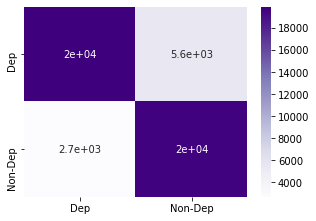

In [0]:
df_cm = pd.DataFrame(cf2, index = [i for i in ["Dep","Non-Dep"]],
                  columns = [i for i in ["Dep","Non-Dep"]])
plt.figure(figsize = (5,3.5))
sn.heatmap(df_cm, annot=True, cmap="Purples")

In [0]:
nltk.download("stopwords")
additional_stopwords = "you that him to it her there etc know want one hey hi yep well really hello a like don't about above after again against all am an and any are aren't as at be because been before being below between both but by can't cannot could couldn't did didn't do does doesn't doing don't down during each few for from further had hadn't has hasn't have haven't having he he'd he'll he's her here here's hers herself him himself his how how's i i'd i'll i'm i've if in into is isn't it it's its itself let's me more most mustn't my myself no nor not of off on once only or other oughtour ours ourselves out over own same shan't she she'd she'll she's should shouldn't so some such than that that's the their theirs them themselves then there there's these they they'd they'll they're they've this those through to too under until up very was wasn't we we'd we'll we're we've were weren't what what's when when's where where's which while who who's whom why why's with won't would wouldn't you you'd you'll you're you've your yours yourself yourselves"
removing_words = 'beyondblue beyond blue tony wk tony geoff neil depression'
englishstop = stopwords.words("english")
englishstop += additional_stopwords.split()
englishstop += removing_words.split()
nopunc = re.sub("'",'',additional_stopwords)
englishstop += nopunc.split()
englishstop = set(englishstop)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
def avg_word(sentence):
    words = sentence.split()
    return (sum(len(word) for word in words)/len([words]))

def pipeline(train1, whatstop):
    train1['LINE_NUM'] = train1['TEXT'].apply(lambda x: str(x).count('\n') - 2)
    train1['WORD_COUNT'] = train1['TEXT'].apply(lambda x: len(str(x).split(" ")))
    train1['CHAR_COUNT'] = train1['TEXT'].str.len() ## this also includes spaces
    train1['TEXT'] = train1['TEXT'].apply(lambda x: re.sub(r'\n',' ',x))
    train1['TEXT'] = train1['TEXT'].str.replace(r'\s+',' ')
    train1['TAG'] = train1['TEXT'].str.contains('@')
    train1['STOPWORDS'] = train1['TEXT'].apply(lambda x: len([x for x in str(x).split() if x in whatstop]))
    train1['HASHTAGS'] = train1['TEXT'].apply(lambda x: len([x for x in str(x).split() if x.startswith('#')]))
    train1['UPPER'] = train1['TEXT'].apply(lambda x: len([x for x in str(x).split() if x.isupper()]))
    train1['NUMERICS'] = train1['TEXT'].apply(lambda x: len([x for x in str(x).split() if x.isdigit()]))
    #train1['AVG_WORDS_LEN'] = train1['TEXT'].apply(lambda x: avg_word(str(x)))
    train1['AVG_WORDS_LEN'] = train1['CHAR_COUNT'] / train1['WORD_COUNT'] # including spaces
    #lexical divercity
    train1['LEXICAL_DIVER'] = train1['TEXT'].apply(lambda x: len(x) / len(set(x)) if len(set(x))>0 else 0 ) 
    return train1

In [0]:
depressed_df.rename(columns={'text': "TEXT"}, inplace=True)

In [0]:
non_depressed_df.rename(columns={'text': "TEXT"}, inplace=True)

In [0]:
depressed_df.head()

,TEXT,label
0,sorry if im stupid but whats activism i dont w...,1
1,ah thank you usually i just see it as a load o...,1
2,lol somebody in my town thought that day was a...,1
3,i really appreciate this post the activism and...,1
4,donate to my mom lol xb,1


In [0]:
dep = pipeline(depressed_df, englishstop)

In [0]:
nondep = pipeline(non_depressed_df, englishstop)

In [0]:
dep.head()

,TEXT,label,LINE_NUM,WORD_COUNT,CHAR_COUNT,TAG,STOPWORDS,HASHTAGS,UPPER,NUMERICS,AVG_WORDS_LEN,LEXICAL_DIVER
0,sorry if im stupid but whats activism i dont w...,1,-2,15,81,False,9,0,0,0,5.400000,3.681818
1,ah thank you usually i just see it as a load o...,1,-2,60,314,False,30,0,0,0,5.233333,13.083333
2,lol somebody in my town thought that day was a...,1,-2,36,172,False,14,0,0,0,4.777778,7.347826
3,i really appreciate this post the activism and...,1,-2,24,135,False,15,0,0,0,5.625000,6.136364
4,donate to my mom lol xb,1,-2,7,24,False,2,0,0,0,3.428571,1.916667


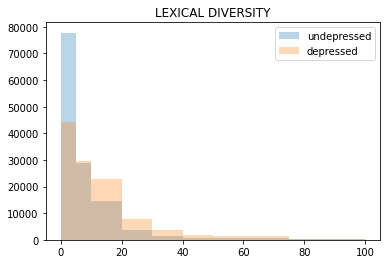

In [0]:
plt.hist(nondep['LEXICAL_DIVER'],label = 'undepressed',alpha = 0.3, bins=[0,5,10,20,30,40,50,75,100])
plt.hist(dep['LEXICAL_DIVER'],label = 'depressed',alpha = 0.3, bins=[0,5,10,20,30,40,50,75,100])
plt.title('LEXICAL DIVERSITY')
plt.legend()
plt.show()

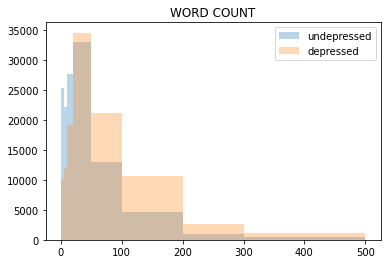

In [0]:
plt.hist(nondep['WORD_COUNT'],label = 'undepressed',alpha = 0.3, bins=[0,5,10,20,50,100,200,300,500])
plt.hist(dep['WORD_COUNT'],label = 'depressed',alpha = 0.3, bins=[0,5,10,20,50,100,200,300,500])
plt.title('WORD COUNT')
plt.legend()
plt.show()

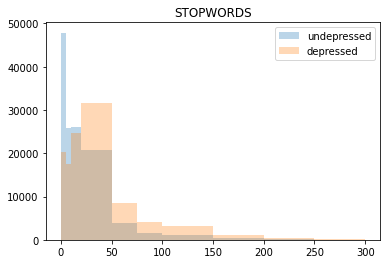

In [0]:
plt.hist(nondep['STOPWORDS'],label = 'undepressed',alpha = 0.3, bins=[0,5,10,20,50,75,100,150,200,250,300])
plt.hist(dep['STOPWORDS'],label = 'depressed',alpha = 0.3, bins=[0,5,10,20,50,75,100,150,200,250,300])
plt.title('STOPWORDS')
plt.legend()
plt.show()

In [0]:
def cleanpipe(train1,whatstop):
    train1['WORKING_TEXT'] = train1['TEXT'].apply(lambda x: " ".join(x.lower() for x in str(x).split()))
    train1['WORKING_TEXT'] = train1['WORKING_TEXT'].str.replace(r'\d+',' ')
    train1['WORKING_TEXT'] = train1['WORKING_TEXT'].str.replace(r'[^\w\s]',' ')
    train1['WORKING_TEXT'] = train1['WORKING_TEXT'].str.replace(r'\s+',' ')
    train1['WORKING_TEXT'] = train1['WORKING_TEXT'].apply(lambda x:" ".join(x for x in x.split() if (x not in whatstop)))
   
    #removing links, and words under 2 chars
    train1['WORKING_TEXT'] = train1['WORKING_TEXT'].apply(lambda x: " ".join(x for x in x.split() if not(x.startswith('www'))))
    train1['WORKING_TEXT'] = train1['WORKING_TEXT'].apply(lambda x: " ".join(x for x in x.split() if not(x.startswith('http'))))                
    train1['WORKING_TEXT'] = train1['WORKING_TEXT'].apply(lambda x: " ".join(x for x in x.split() if not(len(x)< 2)))                

    #removing posts less then 8 words
    train1.drop(train1[train1['WORD_COUNT'] < 8].index,inplace = True)
    
    
    train1 = train1.drop_duplicates(subset = 'WORKING_TEXT')
    return train1


def freqremovel(train1, freq):
    train1['WORKING_TEXT'] = train1['WORKING_TEXT'].apply(lambda x: " ".join(x for x in x.split() if x in freq))
    return train1

In [0]:
dep = cleanpipe(dep,englishstop)
nondep = cleanpipe(nondep,englishstop)

In [0]:
dep.head()

,TEXT,label,LINE_NUM,WORD_COUNT,CHAR_COUNT,TAG,STOPWORDS,HASHTAGS,UPPER,NUMERICS,AVG_WORDS_LEN,LEXICAL_DIVER,WORKING_TEXT
0,sorry if im stupid but whats activism i dont w...,1,-2,15,81,False,9,0,0,0,5.400000,3.681818,sorry stupid activism accidentally break rules
1,ah thank you usually i just see it as a load o...,1,-2,60,314,False,30,0,0,0,5.233333,13.083333,ah thank usually see load horsecrap people wan...
2,lol somebody in my town thought that day was a...,1,-2,36,172,False,14,0,0,0,4.777778,7.347826,lol somebody town thought day good day suicide...
3,i really appreciate this post the activism and...,1,-2,24,135,False,15,0,0,0,5.625000,6.136364,appreciate post activism awareness days honest...
5,basically anything thats aimed at raising awre...,1,-2,54,300,False,24,0,0,0,5.555556,12.375000,basically anything aimed raising awreness mone...


In [0]:
nondep.head()

,TEXT,label,LINE_NUM,WORD_COUNT,CHAR_COUNT,TAG,STOPWORDS,HASHTAGS,UPPER,NUMERICS,AVG_WORDS_LEN,LEXICAL_DIVER,WORKING_TEXT
0,his dad developed huntingtons and his mom left...,0,-2,49,223,False,24,0,0,0,4.551020,9.608696,dad developed huntingtons mom left family resu...
1,got back together with him after years apart w...,0,-2,41,184,False,21,0,0,0,4.487805,8.181818,got back together years apart wonderful years ...
2,she met someone like a decade ago and theyve b...,0,-2,28,137,False,16,0,0,0,4.892857,5.956522,met someone decade ago married many years good...
4,she was an exchange student who i was absolute...,0,-2,91,453,False,55,0,0,0,4.978022,18.875000,exchange student absolutely moon dates think f...
5,she died far too young i taught hockey in cana...,0,-2,190,883,False,102,0,0,0,4.647368,36.250000,died far young taught hockey canada american m...


In [0]:
englishfreq = pd.Series(' '.join(dep['WORKING_TEXT']).split()).value_counts()[220:-600]
newenglish = freqremovel(dep,englishfreq)

neutral_freq = pd.Series(' '.join(nondep['WORKING_TEXT']).split()).value_counts()[150:-200]
neutral_post = freqremovel(nondep,neutral_freq)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3041: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.loc[index, col] = value


In [0]:
from wordcloud import WordCloud

def PostWordCloud(df):
    string = ''
    for line in df['WORKING_TEXT']:
        string = string + str(line)
    wordcloud = WordCloud(background_color='black',max_font_size=60, collocations=False).generate(string)
    plt.figure(figsize=(10,10))
    
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

PostWordCloud(neutral_post)
PostWordCloud(newenglish)